# GSM of C. necator: Comparisons of iCN1361 to RehMBEL1391

In [1]:
import pandas as pd
import cobra
#from cameo import pfba
import json
from itertools import chain
from optlang.symbolics import Zero
from cobra.flux_analysis.variability import flux_variability_analysis
import numpy as np
from cobra.sampling import sample
from cobra.flux_analysis import pfba
import matplotlib.pyplot as plt
from cameo import models
from memote.support.consistency import detect_energy_generating_cycles
from bioservices import kegg

In [2]:
### load the models
cobra.core.configuration.Configuration.solver = 'cplex'
# load the iCN1361
m = cobra.io.read_sbml_model('../Model/iCN1361.xml')
# load the RehMBEL1391 - downloaded from Michael Jahn's github
m2 = cobra.io.read_sbml_model('Data/Jahn2022_files/RehMBEL1391_sbml_L3V1.xml')



## Model properties

In [222]:
# number of reactions
print('number of reactions: ', len(m.reactions), len(m2.reactions))

# number of transporters in iCN1361
transporter = []
for i in m.reactions:
    if 'EX_' in i.id:
        transporter.append(i.id)
    if 'transport' in i.name:
        transporter.append(i.id)
transporter = list(set(transporter))
# number of transporters in RehBMEL1391
transporter2 = []
for i in m2.reactions:
    if 'EX_' in i.id:
        transporter2.append(i.id)
    if 'transport' in i.name:
        transporter2.append(i.id)
transporter2 = list(set(transporter2))        
# number of internal reactions in each model
print('number of transport reactions: ', len(transporter), len(transporter2))
print('number of internal reactions: ', len(m.reactions) - len(transporter), len(m2.reactions) - len(transporter2))

# number of internal metabolites in iCN1361
mets_c = []
for i in m.metabolites:
    if i.compartment == 'c':
        mets_c.append(i.id)
        
# number of internal metabolites in RehMBEL1391        
mets2_c = []
for i in m2.metabolites:
    if i.compartment == 'c':
        mets2_c.append(i.id)

print('number of cytosol metabolites: ', len(mets_c), len(mets2_c))

# any genes in iCN1361 that are not associated with a reaction
unassigned = []
for i in m.genes:
    if len(i.reactions) == 0:
        unassigned.append(i.id)
        

# any genes in RehMBEL1391 that are not associated with a reaction
unassigned2 = []
for i in m2.genes:
    if len(i.reactions) == 0:
        unassigned2.append(i.id)
        
print('number of genes', len(m.genes)- len(unassigned), len(m2.genes)- len(unassigned2))


# number of mass balanced reactions in iCN1361
balanced = []
reacs = []
for i in m.reactions:
    if 'EX_' not in i.id:
        if i.check_mass_balance() == {}:
            balanced.append(i.id)
        reacs.append(i.id)
    
# number of mass balanced reactions in RehMBEL1391 - note that some metabolites are missing metabolites so could come up as not balanced due to this.        
balanced2 = []
reacs2 = []
for i in m2.reactions:
    if 'EX_' not in i.id:
        if i.check_mass_balance() == {}:
            balanced2.append(i.id)
        else:
            if 'C' not in i.check_mass_balance() and 'H' not in i.check_mass_balance() and 'O' not in i.check_mass_balance() and 'P' not in i.check_mass_balance() and 'S' not in i.check_mass_balance():
                balanced2.append(i.id)
        reacs2.append(i.id)

print('Balanced reactions: ', len(balanced)/len(reacs), len(balanced2)/len(reacs2))

# Number of dead reactions in each model (with exchange reactions open)
dead = cobra.flux_analysis.find_blocked_reactions(m, open_exchanges=True)
dead2 = cobra.flux_analysis.find_blocked_reactions(m2, open_exchanges=True)

print('Blocked reactions: ', len(dead), len(dead2))
print('Reactions active: ', len(m.reactions) - len(transporter) - len(dead), len(m2.reactions) - len(transporter2) - len(dead2))



# Energy generation - match the ids in the iCN1361 model (cannot get to work in MEMOTE without)
m.metabolites.M_ATP.annotation['metanetx.chemical'] = 'MNXM3'
m.metabolites.M_GTP.annotation['metanetx.chemical'] = 'MNXM51'
m.metabolites.M_NADH.annotation['metanetx.chemical'] = 'MNXM10'
m.metabolites.M_NADPH.annotation['metanetx.chemical'] = 'MNXM6'
m.metabolites.M_TTP.annotation['metanetx.chemical'] = 'MNXM394'
m.metabolites.M_UTP.annotation['metanetx.chemical'] = 'MNXM121'
m.metabolites.M_CTP.annotation['metanetx.chemical'] = 'MNXM63'
m.metabolites.M_ITP.annotation['metanetx.chemical'] = 'MNXM423'
m.metabolites.M_FADH2.annotation['metanetx.chemical'] = 'MNXM38'
m.metabolites.M_Reduced_flavodoxins.annotation['metanetx.chemical'] = 'MNXM208'
m.metabolites.M_Ubiquinols.annotation['metanetx.chemical'] = 'MNXM191'
m.metabolites.M_Menaquinols.annotation['metanetx.chemical'] = 'MNXM223'
m.metabolites.M_ACETYL_COA.annotation['metanetx.chemical'] = 'MNXM21'
m.metabolites.M_GLT.annotation['metanetx.chemical'] = 'MNXM89557'
m.metabolites.M_CO_A.annotation['metanetx.chemical'] = 'MNXM12'
m.metabolites.M_2_KETOGLUTARATE.annotation['metanetx.chemical'] = 'MNXM20'
m.metabolites.M_ADP.annotation['metanetx.chemical'] = 'MNXM7'
m.metabolites.M_CDP.annotation['metanetx.chemical'] = 'MNXM220'
m.metabolites.M_GDP.annotation['metanetx.chemical'] = 'MNXM30'
m.metabolites.M_UDP.annotation['metanetx.chemical'] = 'MNXM17'
m.metabolites.M_IDP.annotation['metanetx.chemical'] = 'MNXM495'
m.metabolites.M_NADP.annotation['metanetx.chemical'] = 'MNXM5'
m.metabolites.M_NAD.annotation['metanetx.chemical'] = 'MNXM8'
m.metabolites.M_FAD.annotation['metanetx.chemical'] = 'MNXM33'
m.metabolites.M_Oxidized_flavodoxins.annotation['metanetx.chemical'] = 'MNXM119'
m.metabolites.M_Ubiquinones.annotation['metanetx.chemical'] = 'MNXM232'
m.metabolites.M_PROTON.annotation['metanetx.chemical'] = 'MNXM1'
m.metabolites.M_WATER.annotation['metanetx.chemical'] = 'MNXM2'
m.metabolites.M_AMMONIUM.annotation['metanetx.chemical'] = 'MNXM15'



model = m
metabolite_id = 'MNXM3'
ENERGY_COUPLES = {
    "MNXM3": "MNXM7",
    "MNXM63": "MNXM220",
    "MNXM51": "MNXM30",
    "MNXM121": "MNXM17",
    "MNXM423": "MNXM495",
    "MNXM6": "MNXM5",
    "MNXM10": "MNXM8",
    "MNXM38": "MNXM33",
    "MNXM191": "MNXM232",
    "MNXM21": "MNXM12",
    "MNXM89557": "MNXM20",
}

energy_errors = []
for i, j in ENERGY_COUPLES.items():
    metabolite_id = i
    energy_errors.append(detect_energy_generating_cycles(m, metabolite_id))
    m.reactions.Dissipation.remove_from_model()
    
    
energy_errors2 = []
for i, j in ENERGY_COUPLES.items():
    metabolite_id = i
    energy_errors2.append(detect_energy_generating_cycles(m2, metabolite_id))
    m2.reactions.Dissipation.remove_from_model()

energy_cycles_count = 0
for i in energy_errors:
    if i != []:
        energy_cycles_count += 1
        
energy_cycles_count2 = 0
for i in energy_errors2:
    if i != []:
        energy_cycles_count2 += 1
        

print('Erroneous energy-generating cycles: ', energy_cycles_count, energy_cycles_count2)
print('Unconserved metabolites: ', 0, 235) # taken from the MEMOTE report
print('MEMOTE overall score: ' '90%', '60%') # taken from the MEMOTE report 
print('')

# notes:
# Only 162 of the 207 transporters are active in the current model (i.e. not in the set of dead reactions)
# and only 190 of the transporters are missing a gene association, so it's not clear how the original model derived these transporters...
# We include transporters only for those that we know can be transported into the model, but since we're only interested in growth on fructose any other transporters would be dead in the simulations presented anyway. 

number of reactions:  1292 1538
number of transport reactions:  98 384
number of internal reactions:  1194 1154
number of cytosol metabolites:  1263 1172
number of genes 1362 1345
Balanced reactions:  0.9966555183946488 0.4922850844966936
Blocked reactions:  443 593
Reactions active:  751 561
Erroneous energy-generating cycles:  0 0
Unconserved metabolites:  0 235
MEMOTE overall score: 90% 60%



### Notable differences between the model constructions

•	Transport reactions: in our model we added transporters only for minimal media substrates and for carbon sources known to enable growth. Annotating transport reactions is much more challenging, so we only added those for which experimental evidence exists to show the bacteria is capable of utilising the transporter. Transporters were also added for metabolites commonly produced by bacteria, in the same way as [ref - BioCyc]. The transporters in RehMBEL1361 were defined in the original model, but the majority lack a gene annotation so it is unclear whether the transporter is definitely present. 

•	Cell wall metabolism: in our model we include the full pathway for each fatty acid included in the model, where RehMBEL1391 uses a lumped version. Using the full pathway can be useful when integrating transcriptomics data and/or proteomics data (otherwise the genes will need to be weighted according to the individual reactions involved the lumped version), whereas a lumped version can be beneficial when reducing the network size when applying approaches such as optKnock or optGene.  (fatty acids and LPS)

•	Biomass equation: we have used the same biomass as defined in the original RehMBEL1391 model and included the correction identified in [1]. In [2], the original model manuscript, they reference the cellular composition being taken from E. coli values for the protein content, yet the value is considerably higher. We therefore have modified the composition to be close to the E. coli iJO1366 model (see SupplementaryFile1_GSMInfo – Table S4). The way in which the biomass reaction is defined is slightly different in the two models. In iCN1361 we define one biomass reaction that includes all individual biomass components (i.e. alanine + aspartate + dATP + dGTP +  Biomass ), whereas in RehBMEL1391 they include separate reactions for each macromolecule (i.e. protein + DNA + …  Biomass). However, these are just different ways of formulating the biomass equation and do not affect the model results.

•	Enzyme specificity: iCN1361 was constructed using the BioCyc database, whereas the RehMBEL1391 has assigned gene annotations using KEGG and UniProt. These databases sometimes differ in the number of reactions assigned to a gene, due to differences in the predicted substrate specificity of the enzyme. 



$\bf{References}\\$
Weaver, Daniel S., et al. "A genome-scale metabolic flux model of $\it{Escherichia~coli}$ K-12 derived from the EcoCyc database", BMC Systems Biology (2014)


## Model validation

### Carbon source utilisation

In [3]:
carbon_sources = pd.read_excel('Data/Carbon_source_utilisation_phenotypes.xlsx', sheet_name='Sheet1')

In [28]:

substrates = list(carbon_sources['Metabolite ID'])
substrates2 = []
match = {}
match2 = {}
for i in substrates:
    if i[0:3] != 'M_':
        substrates2.append('M_'+i)
        match['M_' + i] = i
        match2[i] = 'M_' + i
    else:
        substrates2.append(i)
        match[i] = i
        match2[i] = i
        

# map the exchange reactions in RehMBEL1391 to the tested carbon sources
reh_exc = {'M_2_PG' : 'EX_2pg_e',
           'M_G3P' : 'EX_3pg_e',
           'M_ACET' : 'EX_ac_e',
           'M_CIT' : 'EX_cit_e',
           'M_BETA_D_FRUCTOSE' : 'EX_fru_e',
           'M_L_LACTATE' : 'EX_lac__L_e',
           'M_D_LACTATE' : 'EX_lac__D_e',
           'M_FUM' : 'EX_fum_e',
           'M_GLYOX' : 'EX_glx_e',
           'M_THREO_DS_ISO_CITRATE' : 'EX_icit_e',
           'M_L_ALPHA_ALANINE' : 'EX_ala__L_e',
           'M_ASN' : 'EX_asn__L_e',
           'M_L_ASPARTATE' : 'EX_asp__L_e',
           'M_GLT' : 'EX_glu__L_e',
           'M_HIS' : 'EX_his__L_e',
           'M_LEU' : 'EX_leu__L_e',
           'M_PHE' : 'EX_phe__L_e',
           'M_PRO' : 'EX_pro__L_e',
           'M_SER' : 'EX_ser__L_e',
           'M_THR' : 'EX_thr__L_e',
           'M_TRP' : 'EX_trp__L_e',
           'M_NIACINE' : 'EX_nac_e',
           'M_PHENOL' : 'EX_phenol_e',
           'M_PHENYLACETATE' : 'EX_pac_e',
           'M_PROPIONATE' : 'EX_ppa_e',
           'M_PYRUVATE' : 'EX_pyr_e',
           'M_SUC' : 'EX_succ_e',
           'M_TREHALOSE' : 'EX_tre_e',
           'M_CARNITINE' : 'EX_crn_e',
           'M_GLC_6_P' : 'EX_g6p_e',
           'M_INOSINE' : 'EX_ins_e',
           'M_PUTRESCINE' : 'EX_ptrc_e',
           'M_THYMIDINE' : 'EX_thymd_e',
           'M_URIDINE' : 'EX_uri_e',
           'M_ETOH' : 'EX_eth_e',
           'M_MAL' : 'EX_mal_e',
           'M_4_AMINO_BUTYRATE' : 'EX_gaba_e',
           'M_GLYCEROL' : 'EX_gl_e',
           'M_GLUCONATE' : 'EX_gluc_e',
           'M_D_ALANINE' : 'EX_dala_e',
           'M_CIS_ACONITATE' : 'EX_acon__C_e',
           'M_BENZALDEHYDE' : 'EX_bzald_e',
           'M_BENZOATE' : 'EX_benzot_e',
           'M_ANTHRANILATE' : 'EX_an_e',
           'M_2_OXOBUTANOATE' : 'EX_obut_e',
           'M_4_hydroxybenzoate' : 'EX_4hb_e',
           'M_CPD_335' : 'EX_r3hbn_e',
           'M_FORMATE' : 'EX_formate_e',
           'M_ADIPATE' : 'EX_adip_e',
           'M_CATECHOL' : 'EX_catech_e',
           'M_BUTYRIC_ACID' : 'EX_butn_e',
           'M_3_HYDROXYBENZOATE' : 'EX_3hbenzot_e', 
           'M_4_FLUOROBENZOATE' : 'EX_4flrbz_e',
           'M_6_CHQ' : 'EX_6chq_e',
           'M_GLYCOLLATE' : 'EX_glycolate_e',
           'M_KYNURENATE' : 'EX_knt_e',
           'M_CPD_108' : 'EX_4cresol_e',    
           'M_2_HYDROXYBUTANOIC_ACID' : 'EX_2hba_e',
           'M_PHENYLGLYOXYLATE' : 'EX_aobzac_e',
           'M_BIPHENYL_23_DIOL' : 'EX_bp23d_e',
           'M_CIS_CIS_MUCONATE' : 'EX_ccmuc_e',
           'M_4_HYDROXY_BUTYRATE' : 'EX_4hbt_e',
           'M_CPD_633' : 'EX_gensa_e',
           'M_CPD_14736' : 'EX_kn_e',
           'M_CPD_741' : 'EX_mclact_e',
           'M_CPD_7836' : 'EX_c140_e',
           'M_OLEATE_CPD' : 'EX_c181_e',
           'M_N_ACETYL_D_GLUCOSAMINE_e' : 'EX_naga_e',
           'M_PALMITATE' : 'EX_c160_e',
           'M_4_HYDROXYPHENYLACETATE' : 'EX_4hpheac_e',
           'M_3_4_DIHYDROXYBENZOATE' : 'EX_34dhb_e',
           'M_UROCANATE' : 'EX_urocan_e',
           'M_alpha-d-lactose' : 'EX_lactose_e',
           'M_D_GALACTONATE' : 'EX_galctn__D_e',
           'M_GLUCURONATE' : 'EX_dgluc_e',
           'M_MANNITOL' : 'EX_mnt_e',
           'M_MANNOSE' : 'EX_man_e',
           'M_MELIBIOSE' : 'EX_meli_e',
           'M_D-SERINE' : 'EX_dser_e', 
           'M_SORBITOL' : 'EX_sot_e',
           'M_ARABINOSE' : 'EX_larabinose_e',
           'M_L-fucose' : 'EX_fuc_e',
           'M_L_ORNITHINE' : 'EX_orn_e',
           'M_D-Rhamnose' : 'EX_rmn_e',
           'M_MALTOSE' : 'EX_mlt_e',
           'M_RIBOSE' : 'EX_rib_e',
           'M_ETHANOL_AMINE' : 'EX_etha_c', 
           'M_ACETOIN' : 'EX_acetoin_c',
           'M_GLC' : 'EX_glc__D_c',
           'M_2_KETOGLUTARATE' : 'EX_akg_c',
           'M_1,3-butanediol' : 'EX_13but_c',
           'M_5_DEHYDROGLUCONATE' : 'EX_5dh4dglc_c',
           'M_adonitol' : 'EX_adon_c',
           'M_alpha-cyclodextrin' : 'EX_alpha-cyclodextrin_c',
           'M_b-methyl-d-glucoside' : 'EX_b-methyl-d-glucoside_c',
           'M_cellobiose' : 'EX_cellobiose_c',
           'M_d-arabitol' : 'EX_d_arabitol_c',
           'M_dextrin' : 'EX_dextrin_c',
           'M_CPD_3617' : 'EX_dodec_c',
           'M_D-galactonic acid lactone' : 'EX_dgalactonic_lactone_c',
           'M_ALPHA_D_GALACTOSE' : 'EX_gal_c',
           'M_D_GALACTURONATE' : 'EX_galur_c',
           'M_GLUCOSAMINATE' : 'EX_glucosaminate_c',
           'M_Glycerol-1-phosphate' : 'EX_glyc1p_c',
           'M_CPD-1099' : 'EX_raff_c',
           'M_D-GLUCARATE' : 'EX_glcr_c',
           'M_Gentiobiose' : 'EX_gentibiose_c',
           'M_GLC_1_P' : 'EX_g1p_c',
           'M_Glycogen' : 'EX_glycogen_c',
           'M_glycyl-l-aspartic acid' : 'EX_glycl_asp_c',
           'M_hydroxy-l-proline' : 'EX_4hpro_c',
           'M_ERYTHRITOL' : 'EX_erythritol_c',
           'M_Isomaltose' : 'EX_imal_c',
           'M_ITACONATE' : 'EX_itcn_c',
           'M_CPD-3561' : 'EX_lactulose_c', 
           'M_L-Mandelate' : 'EX_mand_c',
           'M_MALONATE' : 'EX_malonate_c',
           'M_CPD-112' : 'EX_3cresol_c',  
           'M_Inositols' : 'EX_inositols_c',
           'M_N_acetyl_D_galactosamine' : 'EX_ndgal_c',
           'M_CPD-109' : 'EX_ocresol_c',
           'M_PHENYLETHYLAMINE' : 'EX_peamn_c',
           'M_QUINATE' : 'EX_quin_c',
           'M_CPD-1142' : 'EX_salicin_c',
           'M_SHIKIMATE' : 'EX_skm_c',
           'M_SUCROSE' : 'EX_sucrose_c',
           'M_CPD-13399' : 'EX_tura_c',
           'M_XYLITOL' : 'EX_xylt_c',
           'M_XYLOSE' : 'EX_xyl__D_c',
           'M_Alpha-lactose' : 'EX_lactose_c'
            }

        

In [29]:
# Test without adding transporters for those missing

In [62]:
m2 = cobra.io.read_sbml_model('Data/Jahn2022_files/RehMBEL1391_sbml_L3V1.xml')


# set the constraints
m2.reactions.EX_fru_e.bounds = (0.0, 0.0)
m2.reactions.Maintenance.bounds = (3.0, 1000.0)
m2.objective = 'Biomass'
m2.objective_direction = 'max'
m2.reactions.Biomass.bounds = (0.0, 1000.0)




growth_phenotypes = {}
# check to see if metabolite in the model
for met, exc in reh_exc.items():
    #print(met)
    
    # check if in the model
    run = 1
    with m2:
        if exc in m2.reactions:
            m2.reactions.get_by_id(exc).bounds = (-10.0, 1000.0)
        
        
        
        elif exc not in m2.reactions:
            met_id = exc.split('EX_')[1]
            
            if met_id not in m2.metabolites:
                growth_phenotypes[met] = 0.0
                run = 0
                
            else:
                growth_phenotypes[met] = 0.0
                run = 0
                

                
                
        # check whether solution exists
        if run == 1:
            try:                
                sol = pfba(m2)
                #print(reaction.id, sol[reaction.id], sol['R_Biomass'])
                if sol['Biomass'] > 0.01:
                    growth_phenotypes[met] = 1.0
                else:
                    growth_phenotypes[met] = 0.0
            except:
                growth_phenotypes[met] = 0.0
        
        
        
        
### Print results to dataframe


FP = 0
FN = 0
TP = 0
TN = 0
false_positives = []
false_negatives = []

for i, j in growth_phenotypes.items():
    if j == 1.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    FP += 1
                    false_positives.append(met)
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    TP += 1
                    
                    
    if j == 0.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    TN += 1
                    
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    FN += 1
                    false_negatives.append(met)


print('Number of tested carbon sources: ', len(substrates2))
print('Number of true positives: ', TP)
print('Number of false positives: ', FP)
print('Number of true negatives: ', TN)
print('Number of false negatives: ', FN)
overall_accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Overall accuracy: ',  overall_accuracy)







Number of tested carbon sources:  131
Number of true positives:  60
Number of false positives:  4
Number of true negatives:  63
Number of false negatives:  4
Overall accuracy:  0.9389312977099237


### Test whilst adding transporters for those missing - for a better comparison to iCN1361 

In [44]:
m2 = cobra.io.read_sbml_model('Data/Jahn2022_files/RehMBEL1391_sbml_L3V1.xml')
from cobra.core import Reaction

# set the constraints
m2.reactions.EX_fru_e.bounds = (0.0, 0.0)
m2.reactions.Maintenance.bounds = (3.0, 1000.0)
m2.objective = 'Biomass'
m2.objective_direction = 'max'
m2.reactions.Biomass.bounds = (0.0, 1000.0)




growth_phenotypes = {}
# check to see if metabolite in the model
for met, exc in reh_exc.items():
    #print(met)
    
    # check if in the model
    run = 1
    with m2:
        if exc in m2.reactions:
            m2.reactions.get_by_id(exc).bounds = (-10.0, 1000.0)
        
        
        
        elif exc not in m2.reactions:
            met_id = exc.split('EX_')[1]
            
            if met_id not in m2.metabolites:
                growth_phenotypes[met] = 0.0
                run = 0
                
            else:
                reh_exc_new = Reaction(exc)
                reh_exc_new.add_metabolites({m2.metabolites.get_by_id(met_id) : -1})
                m2.add_reaction(reh_exc_new)
                m2.reactions.get_by_id(exc).bounds = (-10.0, 0.0)
                
                
                

                
                
        # check whether solution exists
        if run == 1:
            try:                
                sol = pfba(m2)
                #print(reaction.id, sol[reaction.id], sol['R_Biomass'])
                if sol['Biomass'] > 0.01:
                    growth_phenotypes[met] = 1.0
                else:
                    growth_phenotypes[met] = 0.0
            except:
                growth_phenotypes[met] = 0.0
        
        
        
### Print results to dataframe


FP = 0
FN = 0
TP = 0
TN = 0
false_positives = []
false_negatives = []

for i, j in growth_phenotypes.items():
    if j == 1.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    FP += 1
                    false_positives.append(met)
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    TP += 1
                    
                    
    if j == 0.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    TN += 1
                    
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    FN += 1
                    false_negatives.append(met)


print('Number of tested carbon sources: ', len(substrates2))
print('Number of true positives: ', TP)
print('Number of false positives: ', FP)
print('Number of true negatives: ', TN)
print('Number of false negatives: ', FN)
overall_accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Overall accuracy: ',  overall_accuracy)        









Number of tested carbon sources:  131
Number of true positives:  60
Number of false positives:  13
Number of true negatives:  54
Number of false negatives:  4
Overall accuracy:  0.8702290076335878


### Comparison to iCN1361
9/15 false positives are overlapping with the false positives found in iCN1361. If we were assume a transporter is not available for these metabolites, as is the case in the RehMBEL1391 model, then the number of false positives would decrease to 6 and the overall accuracy increase to 93%.


|  | iCN1361 | RehMBEL1391 |
|--|---------|-------------|
| Number of TPs | 62 | 60 |
| Number of FPs | 6 | 4 |
| Number of TNs | 61 | 63 |
| Number of FNs | 3 | 4 |
| Overall accuracy | 93% | 94% |



### Flux predictions - growth on fructose

In [72]:
m2 = cobra.io.read_sbml_model('Data/Jahn2022_files/RehMBEL1391_sbml_L3V1.xml')

m2.reactions.EX_fru_e.bounds = (-2.6, -2.6)
m2.reactions.FRUpts.bounds = (0.0, 0.0) # previous study found the ABC is the active reaction [ref]
m2.reactions.FRUpts2.bounds = (0.0, 0.0)
#m2.reactions.EX_h_e.bounds = (0.0, 0.0)
m2.reactions.Maintenance.bounds = (3.0, 1000.0) # wasn't already constrained - do they include somewhere else?
m2.objective = 'Biomass'
sol_fru2 = pfba(m2)

print('Growth rate: ', sol_fru2['Biomass'])
for i in m2.reactions:
    if 'EX_' in i.id:
        if abs(sol_fru2[i.id]) > 0.0:
            print(i.id, sol_fru2[i.id])

Growth rate:  0.233978640837583
EX_fe2_e -5.194325826594343e-05
EX_BIOMASS_c 0.233978640837583
EX_pi_e -6.5503466997821445
EX_so4_e -0.04754679960460524
EX_fru_e -2.6
EX_nh4_e -2.491430188299773
EX_co2_e 5.882062496419901
EX_o2_e -5.539665630907597
EX_h2o_e 20.411560733340526
EX_h_e -8.795573784200476



| Flux             | Experimental  | iCN1361 | RehMBEL1391. | iJO1366 |
|------------------|---------------|---------|-------------|---------|
| Growth rate      | 0.25 +/- 0.08 | 0.25    | 0.23       | 0.25    |
| Fructose uptake  | 2.6 +/- 0.9   | 2.6*    | 2.6*        | 2.6*    |
| Oxygen uptake    | 4.6 +/- 0.3   | 4.91     | 5.54         | 5.0     |
| Ammonium uptake  |               | 2.63     | 2.49         | 2.65     |
| Sulfate uptake   |               | 0.04    | 0.05        | 0.06    |
| Phosphate uptake |               | 0.22    | 6.55       | 0.24    |
| CO2 production   |               | 5.21    | 5.54         | 5.5     |
| H2O production   |               | 11.95    | 20.41        | 12.0   |
| H+ production    |               | 2.31    | -8.80       | 2.26   |

In general, iCN1361 and RehMBEL1391 show very similar uptake/production flux and growth rate for growth on fructose. The growth rate is slightly lower in RehMBEL1391 and oxygen uptake slightly higher when compared to experimental results. Also, notable is that RehMBEL1391 consumes protons rather than produces protons, which is probably a result of some reactions not being balanced. If we don't allow protons being transported inside the cell then the growth rate reduces to only 0.2 1/h. The phosphate uptake is also surprisingly high compared to the E. coli model. 

### 13-C comparisons

In [4]:

c13_model = pd.read_excel('Data/C13_MFA_results.xlsx', sheet_name='Sheet1')
reac_mappings = pd.read_excel('Data/ReactionName_mappings.xlsx', sheet_name='Sheet1')




#### Map the central carbon metabolism reactions in RehMBEL1391 to iCN1361

In [73]:

reac_map = {}
reac_map['R_PGLUCISOM_RXN'] = 'PGI'
reac_map['R_FRUCTOKINASE_RXN'] = 'HEXf'
reac_map['R_GLU6PDEHYDROG_RXN'] = 'G6PDH2r'
reac_map['R_6PGLUCONOLACT_RXN'] = 'PGL'
reac_map['R_PGLUCONDEHYDRAT_RXN'] = 'EDD'
reac_map['R_KDPGALDOL_RXN'] = 'EDA'
reac_map['R_2TRANSKETO_RXN'] = 'TKT2'
reac_map['R_TRANSALDOL_RXN'] = 'TAh'
reac_map['R_1TRANSKETO_RXN'] = 'TKT1'
reac_map['R_SEDOHEPTULOSE_BISPHOSPHATASE_RXN'] = 'missing'
reac_map['R_SEDOBISALDOL_RXN'] = 'missing'
reac_map['R_RIB5PISOM_RXN'] = 'RPI'
reac_map['R_RIBULP3EPIM_RXN'] = 'RPE'
reac_map['R_PHOSPHORIBULOKINASE_RXN'] = 'PRUK'
reac_map['R_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN'] = 'RBPC'
reac_map['R_PHOSGLYPHOS_RXN'] = 'PGK'
reac_map['R_3PGAREARR_RXN'] = 'PGM'
reac_map['R_GAPOXNPHOSPHN_RXN'] = 'GAPD'
reac_map['R_F16ALDOLASE_RXN'] = 'FBA'
reac_map['R_TRIOSEPISOMERIZATION_RXN'] = 'TPI'
reac_map['R_F16BDEPHOS_RXN'] = 'FBP'
reac_map['R_2PGADEHYDRAT_RXN'] = 'ENO'
reac_map['R_PEPSYNTH_RXN'] = 'PPS'
reac_map['R_PEPDEPHOS_RXN'] = 'PYK'
reac_map['R_PEPCARBOX_RXN'] = 'PPC'
reac_map['R_PEPCARBOX_RXN2'] = 'PPC'
reac_map['R_MALIC_NADP_RXN'] = 'ME2'
reac_map['R_MALATE_DEH_RXN'] = 'ME1'
reac_map['R_RXN0_1134'] = 'PDH1'
reac_map['R_OXALODECARB_RXN'] = 'missing'
reac_map['R_CITSYN_RXN'] = 'CS'
reac_map['R_ACONITATEDEHYDR_RXN'] = 'ACONT1'
reac_map['R_ISOCIT_CLEAV_RXN'] = 'ICL'
reac_map['R_ISOCITDEH_RXN'] = 'ICDHyr'
reac_map['R_ISOCITRATE_DEHYDROGENASE_NAD_RXN'] = 'ICDHx'
reac_map['R_2OXOGLUTDECARB_RXN'] = 'AKGDH'
reac_map['R_SUCCCOASYN_RXN'] = 'SUCOAS'
reac_map['R_SUCCINATE_DEHYDROGENASE_UBIQUINONE_RXN'] = 'SUCDi'
reac_map['R_FUMHYDR_RXN'] = 'FUM'
reac_map['R_MALSYN_RXN'] = 'MALS'
reac_map['R_MALATE_DEH_RXN'] = 'MDH'

In [74]:
# identify the reactions that are in the reverse direction
change_dir = ['TKT1', 'RBPC', 'TPI', 'PYK', 'PPC', 'FUM']

#### Calculate the correlation to the 13-C data

R correlation coefficient:  0.9265077646334658 p-value:  1.0579177759124846e-14
R-Squared correlation coefficient:  0.8584166379261018


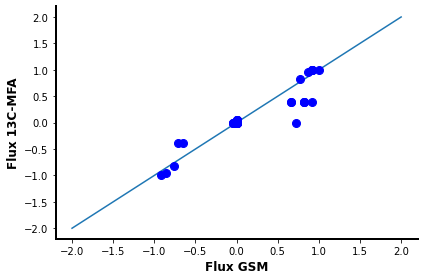

In [75]:


# Exclude the anaplerosis reactions
reactions_exclude = ['R_OXALODECARB_RXN', 'R_PEPSYNTH_RXN', 'R_PEPDEPHOS_RXN', 'R_PEPCARBOX_RXN', 'R_PEPCARBOX_RXN2', 'R_MALIC_NADP_RXN']

# Compare the results and add to list for correlation
gsm2_vals = []
c13_vals = []
c13_vals2 = {}
gsm2_vals2 = {}
for ind, r in enumerate(c13_model['Reaction ID']):
    reacs = r.split(';')
    if reacs[0] not in reactions_exclude:
        if len(reacs) > 1.0:
            sum_flux = 0.0
            for reaci in reacs:
                reh_name = reac_map[reaci]
                sum_flux2 = 0.0
                if reh_name != 'missing':
                    if ' // ' in reh_name:
                        reh_names = reh_name.split(' // ')
                        for r in reh_names:
                            sum_flux2 += sol_fru2[r]
                            if r in change_dir:
                                sum_flux2 = sum_flux2*-1.0
                                
                                
    
                    else:
                        sum_flux2 = sol_fru2[reh_name]
                        if reh_name in change_dir:
                            sum_flux2 = sum_flux2*1.0
                else:
                    sum_flux2 = 0.0
                            
                sum_flux += sum_flux2/2.6 # normalise the flux to 1 mmol/gDCW/h of fructose

            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            c13_vals2[reaci] = c13_model['13C-MFA'][ind]
            gsm2_vals.append(float(sum_flux))
            gsm2_vals2[reaci] = float(sum_flux)
           
        else:
            reh_name = reac_map[reacs[0]]
            sum_flux2 = 0.0
            if reh_name != 'missing':
                if ' // ' in reh_name:
                    reh_names = reh_name.split(' // ')
                    for r in reh_names:
                        if r in change_dir:
                            sum_flux2 += sol_fru2[r]
                            if r in change_dir:
                                sum_flux2 = sum_flux2*-1.0
                else:
                    sum_flux2 = sol_fru2[reh_name]
                    if reh_name in change_dir:
                            sum_flux2 = sum_flux2*-1.0
            else:
                sum_flux2 = 0.0
                            
            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            gsm2_vals.append(float(sum_flux2/2.6))
            c13_vals2[reacs[0]] = c13_model['13C-MFA'][ind]
            gsm2_vals2[reacs[0]] = sum_flux2/2.6
                 
        
        
from scipy import stats

x = np.linspace(-2, 2,2)
y = x
plt.plot(x, y)

plt.plot(gsm2_vals, c13_vals, 'bo', markersize = 8)
axes = plt.gca()

plt.rc('axes', linewidth = 2.0)
plt.xticks(fontsize=10, weight = 'normal')
plt.yticks(fontsize=10, weight = 'normal')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('Flux GSM', fontsize = 12, weight = "bold")
plt.ylabel('Flux 13C-MFA', fontsize = 12, weight = "bold")
plt.savefig('C13_Correlation.png', format = 'png')
plt.tight_layout()
slope, intercept, r_value_bio_out, p_value, std_err = stats.linregress(gsm2_vals, c13_vals)
print('R correlation coefficient: ', r_value_bio_out, 'p-value: ', p_value)
print('R-Squared correlation coefficient: ', r_value_bio_out**2)

#### Carry out FVA to show variability in model for comparing to 13C data

In [78]:
C13reacs = [] # only run FVA on the reactions in central carbon metabolism to save time
for ind, r in enumerate(c13_vals2.keys()):
    if reac_map[r] != 'missing':
        reacs = r.split(';')
        for reac in reacs:
            C13reacs.append(reac_map[reac])
            
reac_map2 = {}
for i, j in reac_map.items():
    reac_map2[j] = i

In [77]:
res90 = flux_variability_analysis(m2, fraction_of_optimum = 0.9, reaction_list=C13reacs, processes = 6, pfba_factor= 1.2)



In [79]:
count = 0.0
for ind, i in enumerate(res90['minimum']):
    reac_name = reac_map2[res90['minimum'].index[ind]]
    if reac_name in c13_vals2:
        if res90['minimum'][ind]/2.6 <= c13_vals2[reac_name] <= res90['maximum'][ind]/2.6:
            count += 1.0
        else:
            print(res90['minimum'].index[ind], i/2.6, res90['maximum'][ind]/2.6, c13_vals2[reac_name]) 
    else:
        print(reac_name)
            
print('Number of reactions that agree with the FVA ranges: ', count)

TKT2 -0.4862838277828041 -0.03965900165647283 -0.008
RPE -0.9323499669098846 -0.03910031465722393 -0.008
RBPC 0.0 1.3152712470616144 -0.005
CS 0.6113109107249172 2.499100720794289 0.393
ACONT1 0.6113109107249172 1.5808311286877743 0.393
FUM 0.4973604108918595 1.484443933566788 -0.393
Number of reactions that agree with the FVA ranges:  25.0


#### 13-C data comparison between models - conclusion

Both iCN1361 and RehMBEL1391 show very similar fluxes for central carbon metabolism. When comparing to the 13C data iCN1361 shows a correlation of 0.88 (r-squared), whereas RehMBEL1391 shows a correlation of 0.85 (r-squared). 

### Gene knockout phenotype predictions

In [5]:

# load tradis data

IPKM_fmm = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'IPKM_FMM')
IPKM_sob = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'IPKM_SOB')
low_coverage = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'low_coverage')



In [6]:
# take the logarithm + 1 of the IPKM values for both SOB and FMM media conditions
log2_IPKM = {}
for ind, gene in enumerate(IPKM_fmm['Unnamed: 0']):
    log2_IPKM[gene] = np.log2(IPKM_fmm['IPKM_curated'][ind] + 1)
    
log2_IPKM_sob = {}
for ind, gene in enumerate(IPKM_sob['Unnamed: 0']):
    log2_IPKM_sob[gene] = np.log2(IPKM_sob['IPKM_curated'][ind] + 1)

In [82]:
# Add column to excel file with GSM result
m2.reactions.Biomass.bounds = (0.0, 1000.0)
m2.reactions.FRUpts.bounds = (0.0, 0.0)
m2.reactions.FRUpts2.bounds = (0.0, 0.0)
m2.reactions.EX_fru_e.bounds = (-2.6, -2.6)

# minimal media
essential_reh = []
non_essential_reh = []

sol_wt = pfba(m2)
growth_wt = sol_wt['Biomass']
for ind, i in enumerate(m2.genes):
    #print(ind, i.id)
    with m2:
        m2.genes.get_by_id(i.id).knock_out()
        try:
            sol_ko = m2.optimize()
            if sol_ko.status != 'infeasible':
                if sol_ko['Biomass'] > 0.05:
                    #print(sol_ko['R_Biomass'])
                    non_essential_reh.append(i.id)

                else:
                    essential_reh.append(i.id)
            
            else:
                essential_reh.append(i.id)

        except:
            essential_reh.append(i.id)
            
            
            
           

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [83]:
### Get the false positives, false negatives
# How many genes are non-essential but low IPKM
false_negatives2 = []
false_positives2 = []
true_negatives2 = []
true_positives2 = []

# low coverage genes
low_coverage_genes = []
for ind, i in enumerate(low_coverage['Low coverage']):
    low_coverage_genes.append(i)

for gene in non_essential_reh:
    if gene not in low_coverage_genes:
        if gene in log2_IPKM:
            if log2_IPKM[gene] < 4.24:        
                #print(gene)
                false_negatives2.append(gene)
            elif log2_IPKM[gene] > 4.24:
                true_negatives2.append(gene)



for gene in essential_reh:
    if gene != 'Spontaneous':
        if gene not in low_coverage_genes:
            if gene in log2_IPKM:
                if log2_IPKM[gene] > 4.24 and log2_IPKM_sob[gene] > 4.24:        
                    #print(gene)
                    false_positives2.append(gene)
                elif log2_IPKM[gene] < 4.24 or log2_IPKM_sob[gene] < 4.24:
                    true_positives2.append(gene)




            

In [84]:
print('Overall accuracy RehMBEL: ', (len(true_positives2) + len(true_negatives2))/(len(true_positives2) + len(true_negatives2) + len(false_negatives2) + len(false_positives2)))
print('Precision RehMBEL: ', len(true_positives2)/(len(true_positives2)+ len(false_positives2)))
print('Recall RehMBEL: ', len(true_positives2)/(len(true_positives2) + len(false_negatives2)))

Overall accuracy RehMBEL:  0.8803212851405623
Precision RehMBEL:  0.7407407407407407
Recall RehMBEL:  0.5286343612334802


#### Comparison to the results of iCN1361


|  | iCN1361 | RehMBEL1391 |
|--|---------|-------------|
| Overall accuracy | 92% | 88% |
| Recall | 62% | 53% |
| Precision | 81% | 74% |


